   ## Customer Value using Recency-Frequency-Monetary(RFM) value metric 

The RFM idea is commonly used in retail to perform [customer segmentation](https://thegood.com/insights/rfm-analysis-convert/).In this work, we will use the RFM value for feature selection. To begin with, rather than consider all three attributes, we will compute an RFM score as a weighted combination of the customers recency, frequency and monetary value attributes. The $RFM\_score$ for a customer, $c$, is computed as:

$$ RFM\_score_{c} = weight_{frequency} . frequency_c + weight_{recency}. frequency_c + weight_{monetary value} monetary\_value_c$$

Recall that the customer, $c$, is represented in terms of the items he or she has purchased at the store. There are $2505$ items in the inventory purchased by the frequent shopper group. The purpose of this notebook is to apply a feature selection algorithm to reduce this high dimensional representation to a more tractable one. We will illustrate that most of the customer value in the store is associated with a small set of store inventory items. We will posit a linear relationship between the $RFM\_score$ for a customer and their store purchases,i.e., $$ RFM\_score_c = \sum_{i=1}^{i=d}s_{ci} \beta_i$$. Here $s_{ci}$ indicates the amount spent by customer, $c$, on item, $i$, at the store. The $\beta_i$ are model coefficients.  Later in this work, we will evaluate if assuming such a linear model between the $RFM\_score$ and the customer purchases is reasonable. In this work, we will add other constraints to this linear relationship. In particular, we will use an idea called _regularization_ with the model. In a conventional linear model, the coefficients, $\beta_i$, are determined by minimizing the error between the model estimates and the actual observed value. In a _regularized_ model, an additional constraint is placed, we want to make these coefficients as small as possible, driving them to a zero value, if possible. The __Least Angle Shrinkage Selector__ [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics)) is a popular and effective linear model with this regularization feature. Expressed as matrices, the model we are using here is:
$$ RFM\_score = \mathbf{S}.\mathbf{\beta}$$

where:

$RFM\_score$, is a $N \times 1$ matrix of computed RFM scores,

$\mathbf{S}$, is a $N \times d$ matrix of customer spend on items,

$\mathbf{\beta}$, is a $d \times 1$ matrix of model coefficients.

The LASSO minimizes the following objective to determine the best linear model:
$$min_{\beta \in \mathcal{R}^d} \left\{\frac{1}{N} \left\| RFM\_score - \mathbf{s}\mathbf{\beta} \right\|^2  + \lambda \left\|\mathbf{\beta}\right\|_1 \right\} $$

There are $2505$ inventory items for this group and there are $618$ customers in the frequent shopper group. So $d=2505,\ N= 618$, in the above equation. An examination of the above objective shows that applying LASSO to estimate a linear model requires the selection of the regularization parameter $\lambda$. Once this parameter is selected, the LASSO solution can be computed. After computing the LASSO solution, the model coefficients, $\beta$ are known. Since we are using LASSO for feature selection, we need to determine how many features we want to select from the model. As we will illustrate, a small proportion of these coefficients account for most of the customer value. We will use an experiment to determine the optimal number of features to extract for this dataset. We will use cross-validation to determine the optimal value of the regularization parameter, $\lambda$. We will then evaluate if our assumption about using a linear model for customer value, for the purposes of feature selection, is a reasonable one. Before the linear model can be applied to the data, there is an important pre-processing step. Linear models work best when the response, in this case, the $RFM\_score$ is _Normally_ distributed. An evaluation of the distribution of the $RFM\_score$ shows a skewed, non-normal distribution. A [_Box-Cox](https://en.wikipedia.org/wiki/Power_transform) transformation is used to transform the $RFM\_score$ to a normal distribution. 

 The workflow for this notebook is shown below ![workflow](img/feature_selection_overview.png)



In [1]:
import pandas as pd
import numpy as np
fp = "data/user_item_utility_matrix.csv"
df = pd.read_csv(fp)
df_u = df["Customer ID"]
col_y = ["MonetaryValue", "freq", "recency"] 
cols = df.columns.tolist()
col_exclude = ["MonetaryValue", "freq", "recency", "Customer ID"]
col_x = [ c for c in cols if c not in col_exclude]
df_y = df[col_y]
df_x = df[col_x]

In [2]:
df_x.shape

(618, 2505)

In [3]:
from sklearn import preprocessing
x = df_y.values #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)
df_y = pd.DataFrame(x_scaled)
df_y.columns = col_y

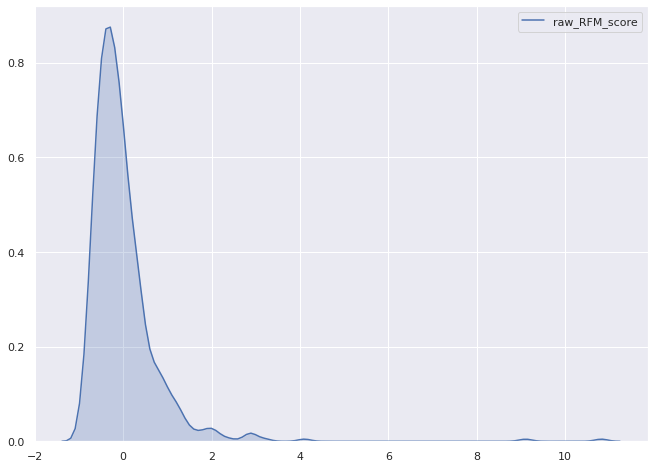

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
weights = {'wt_mv':0.7, 'wt_freq': 0.15, 'wt_rec': 0.15}
def assign_raw_RFM_score(row):
    score = weights['wt_mv']*row["MonetaryValue"] + \
    weights["wt_freq"] * row["freq"] + weights["wt_rec"]*  row["recency"]
    return score
df_y['raw_RFM_score'] = df_y.apply(func = assign_raw_RFM_score, axis = 1)

plt.rcParams['figure.figsize'] = [11, 8]
sns.set(color_codes=True)
sns.kdeplot(df_y["raw_RFM_score"], shade = True)

In [5]:
df_y = df[col_y]
df_y.describe()

,MonetaryValue,freq,recency
count,618.000000,618.000000,618.000000
mean,2377.134045,9.241100,0.098083
std,1934.444008,9.849851,0.174219
min,70.020000,5.000000,0.001499
25%,1335.452500,6.000000,0.018549
50%,1993.995000,7.000000,0.041215
75%,2897.127500,10.000000,0.076789
max,26832.500000,184.000000,1.000000


In [6]:
from sklearn.preprocessing import power_transform
trans_y = power_transform(df_y, method='box-cox', standardize=False)

In [7]:
df_trans_y = pd.DataFrame(trans_y)
df_trans_y.columns = ["bc_MV", "bc_freq", "bc_recency"]
weights = {'wt_mv':0.7, 'wt_freq': 0.15, 'wt_rec': 0.15}
def assign_RFM_score(row):
    score = weights['wt_mv']*row["bc_MV"] + \
    weights["wt_freq"] * row["bc_freq"] + weights["wt_rec"]*  row["bc_recency"]
    return score
df_trans_y['RFM_score'] = df_trans_y.apply(func = assign_RFM_score, axis = 1)

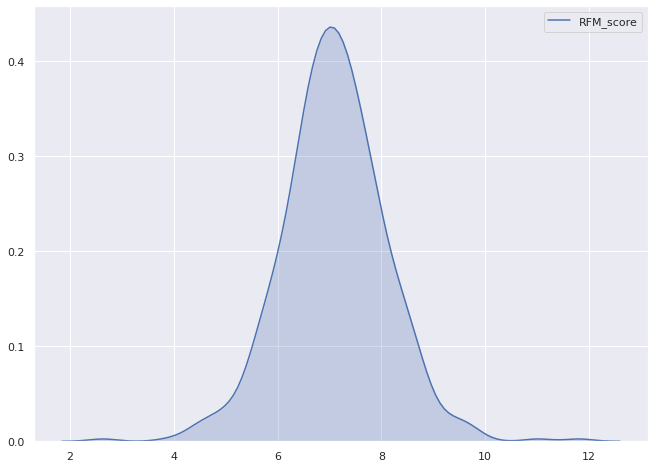

In [8]:
plt.rcParams['figure.figsize'] = [11, 8]
sns.set(color_codes=True)
sns.kdeplot(df_trans_y["RFM_score"], shade = True)

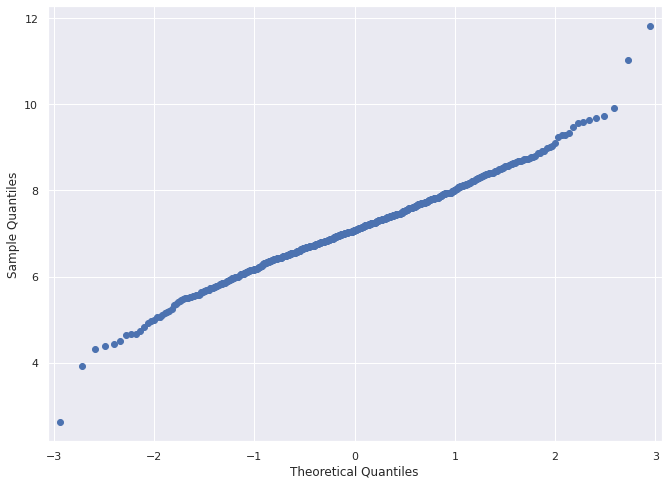

In [9]:
import statsmodels.api as sm
fig = sm.qqplot(df_trans_y["RFM_score"])
plt.show()

In [10]:
Y = df_trans_y["RFM_score"].values
X = df_x.values


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
TRNG_SIZE = X_train.shape[0]
TEST_SIZE = X_test.shape[0]

/home/admin2/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


           Metric  Value
0    Training MSE  0.209
1        Test MSE  0.493
2  Training $R^2$  0.773
3      Test $R^2$  0.558


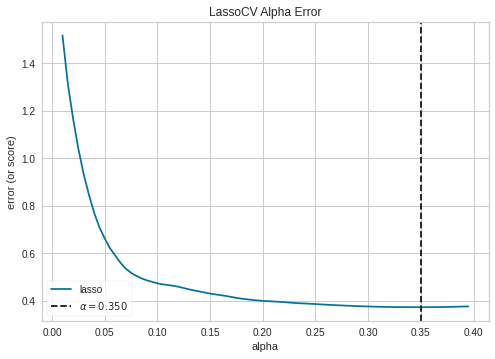

In [12]:
from yellowbrick.regressor import AlphaSelection
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
Xexp = X_train
Yexp = Y_train
Xtexp = X_test
Ytexp = Y_test
alphas = np.arange(0.01, 0.4, 0.005)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

#reg_exp = ElasticNetCV(alphas = alphas, cv = kfold, max_iter=10000)
reg_exp = LassoCV(alphas = alphas, cv = kfold, max_iter=10000)

reg_exp.fit(Xexp, Yexp.ravel())
exp_score = reg_exp.score(Xexp, Yexp)
y_trng_pred = reg_exp.predict(Xexp)
y_test_pred = reg_exp.predict(Xtexp)
trng_fit_score = "%0.3f"%reg_exp.score(Xexp, Yexp)
test_fit_score = "%0.3f"%reg_exp.score(Xtexp, Ytexp)
e_trng_mse = "%0.3f"%mean_squared_error(Yexp, y_trng_pred)
e_test_mse = "%0.3f"%mean_squared_error(Ytexp,y_test_pred)

fes = {"Training MSE": e_trng_mse,
       "Test MSE": e_test_mse,
       "Training $R^2$": trng_fit_score,
       "Test $R^2$": test_fit_score}
df_fes = pd.DataFrame(fes.items())
df_fes.columns = ["Metric", "Value"]
print(df_fes)
visualizer = AlphaSelection(reg_exp)
visualizer.fit(Xexp, Yexp)
visualizer.show()

In [13]:
ord_indices = reg_exp.coef_.ravel().argsort()[::-1]
num_features = np.arange(2,200, 2)
from sklearn.linear_model import LinearRegression
trng_err = []
test_err = []
for nf in num_features:
    Xtrngexp = X_train[:, ord_indices[:nf]]
    Xtestexp = X_test[:, ord_indices[:nf]]
    Ytrngexp = Y_train
    Ytestexp = Y_test
    rfsm = LinearRegression()
    rfsm.fit(Xtrngexp, Ytrngexp.ravel())
    y_trng_pred = rfsm.predict(Xtrngexp)
    y_test_pred = rfsm.predict(Xtestexp)
    trngmse = round(mean_squared_error(Y_train, y_trng_pred), 3)
    testmse = round(mean_squared_error(Y_test, y_test_pred), 3)
    trng_err.append(trngmse)
    test_err.append(testmse)
    gap_ratio = float(trngmse)/float(testmse)
    #print('for {} features, training error is {}, test error is {}'.format(nf, trngmse, testmse))
    #print('for {} features, gap_ratio is {:.3f}, training error is {}, test err is {}'.format(nf, gap_ratio, trngmse, testmse))
    

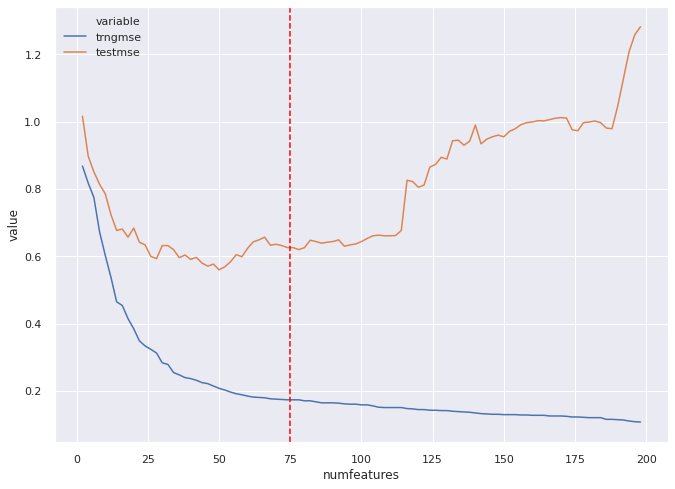

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
NUM_FEATURES_OPT = 75
aed = {"numfeatures": num_features, "trngmse": trng_err, "testmse": test_err}
df_nf_sel = pd.DataFrame(aed)
cols_to_plot = ["numfeatures", "trngmse", "testmse"]
df_plot = df_nf_sel[cols_to_plot]
df_ep = df_plot.melt(id_vars = ['numfeatures'])
df_ep["value"] = df_ep["value"].astype(np.float)

plt.rcParams['figure.figsize'] = [11, 8]
sns.set(color_codes=True)
sns.lineplot(x='numfeatures', y='value', hue='variable', data = df_ep)
plt.axvline(x = NUM_FEATURES_OPT, color ='red', linestyle= '--') 

Text(0.5, 1.0, 'Actual vs Fitted Values (test set)')

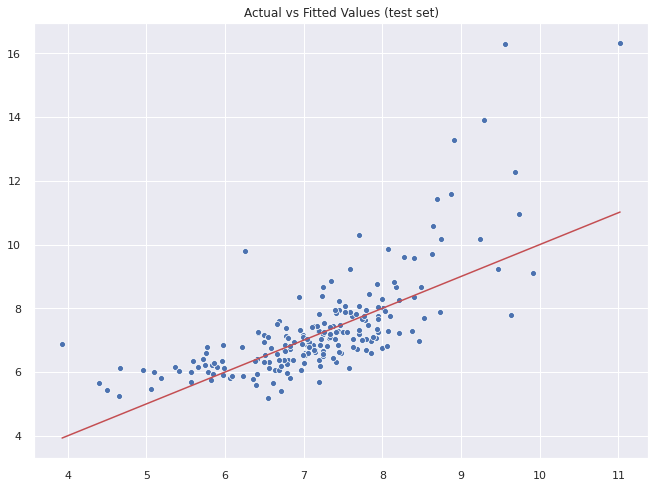

In [15]:
plt.rcParams['figure.figsize'] = [11, 8]
sns.set(color_codes=True)
xp = np.linspace(Ytestexp.ravel().min(), Ytestexp.ravel().max(), 30)
yp = xp
g = sns.scatterplot(x=Ytestexp.ravel(), y=y_test_pred.ravel())
plt.plot(xp, yp, color='r')
plt.title("Actual vs Fitted Values (test set)")

In [16]:
feats = col_x
if "Customer ID" in feats:
    feats.remove("Customer ID")
feats = np.array(feats)
bm_ord_ind = reg_exp.coef_.ravel().argsort()[::-1]
feats = feats.ravel()[bm_ord_ind][:NUM_FEATURES_OPT]
bmcoefs = reg_exp.coef_.ravel()[bm_ord_ind][:NUM_FEATURES_OPT]

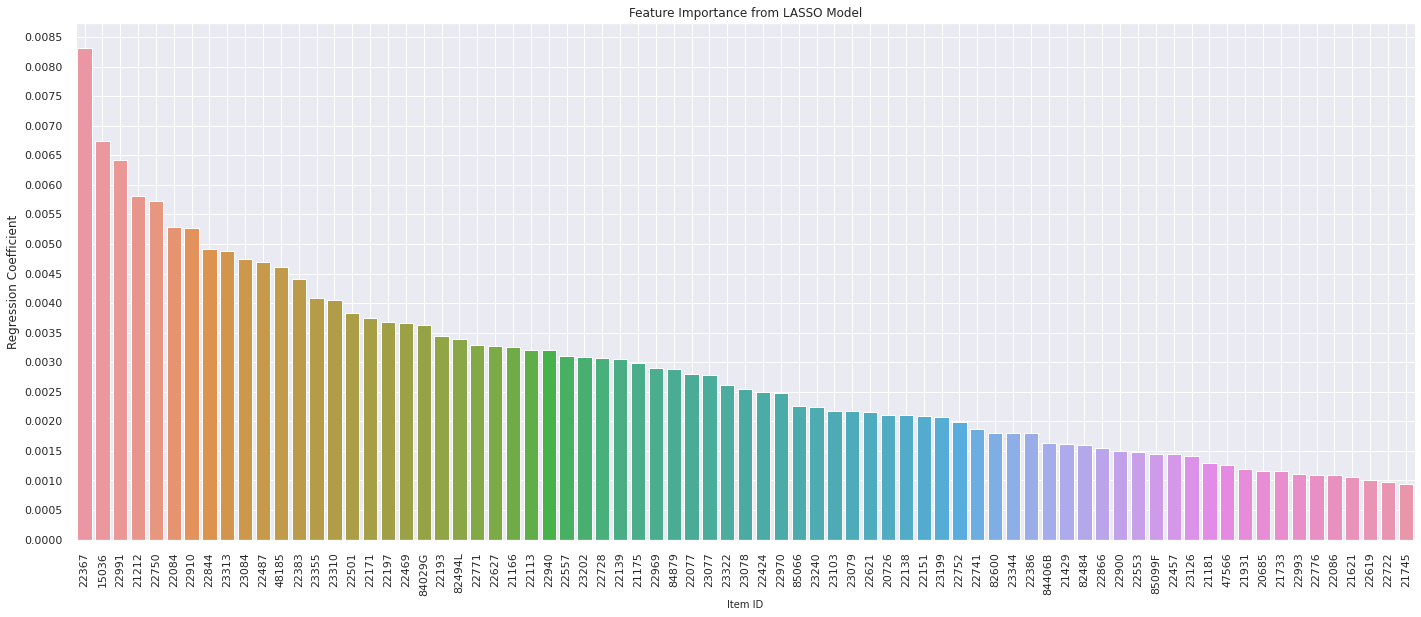

In [17]:
import matplotlib.ticker as ticker
plt.rcParams['figure.figsize'] = [24, 9.5]
plt.rcParams['xtick.labelsize'] = 'xx-small'
sns.set(color_codes=True)
g = sns.barplot(x = feats, y = bmcoefs, ci = None)
plt.title("Feature Importance from LASSO Model")
plt.grid(True)
plt.xlabel('Item ID', fontsize=10)
plt.ylabel('Regression Coefficient')
plt.locator_params(axis='y', nbins=20)
l = g.set_xticklabels(feats, rotation=90)

In [18]:
Xfs = X[:, bm_ord_ind[:NUM_FEATURES_OPT]]
Yfs = Y
df_fs = pd.DataFrame(Xfs)
df_fs.columns = feats
df_fs["RFM_score"] = Y
df_fs["Customer_ID"] = df_u
df_fs = df_fs.set_index("Customer_ID")
fp = "data/feature_selected_freq_shoppers.csv"
df_fs.to_csv(fp)